<a href="https://colab.research.google.com/github/mikgroup/extreme_mri/blob/master/colab-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extreme MRI Demo

This notebook demonstrates an [Extreme MRI: Large-Scale Volumetric Dynamic Imaging from Continuous Non-Gated Acquisitions](https://arxiv.org/abs/1909.13482) reconstruction with a DCE dataset. 

# Install and Import packages

Let's install and import the relevant packages. In particular, the reconstruction depends on [CuPy](https://cupy.chainer.org) and [SigPy](http://sigpy.readthedocs.io).

In [11]:
! pip install sigpy h5py
! git clone https://github.com/mikgroup/extreme_mri
% cd extreme_mri

fatal: destination path 'extreme_mri' already exists and is not an empty directory.
/content/extreme_mri


In [0]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

from download_dataset import download_dce_dataset
from gridding_recon import gridding_recon
from multi_scale_low_rank_recon import MultiScaleLowRankRecon

# Set computing device

We need to specify a computing device for the reconstruction.
For CPU, the id would -1. For GPUs, the id would be the GPU device.

We strongly recommend using GPUs for reconstruction.

In [0]:
device = 0

# Download and Load dataset

Now, let's download and load the DCE dataset. The dataset is hosted on Zenodo: https://zenodo.org/record/3647820, and corresponds to the second DCE dataset described in the paper.

The `download_dce_dataset()` function will download the datasets if it cannot find them under `data/dce/`.

In [0]:
download_dce_dataset()
ksp = np.load('data/dce/ksp.npy')
coord = np.load('data/dce/coord.npy')
dcf = np.load('data/dce/dcf.npy')

# (Optional) Speed up reconstruction by cropping k-space

For speeding up the demo, we can crop the k-space data along readout to reconstruct low resolution images.

Simply comment out this part if you like to perform the full-resolution reconstruction.

In [0]:
num_ro = 150  # number of readout points
ksp = ksp[:, :, :num_ro]
coord = coord[:, :num_ro]
dcf = dcf[:, :num_ro]

# Gridding reconstruction

Let's first do a gridding reconstruction to see what the image looks like.

<IPython.core.display.Javascript object>


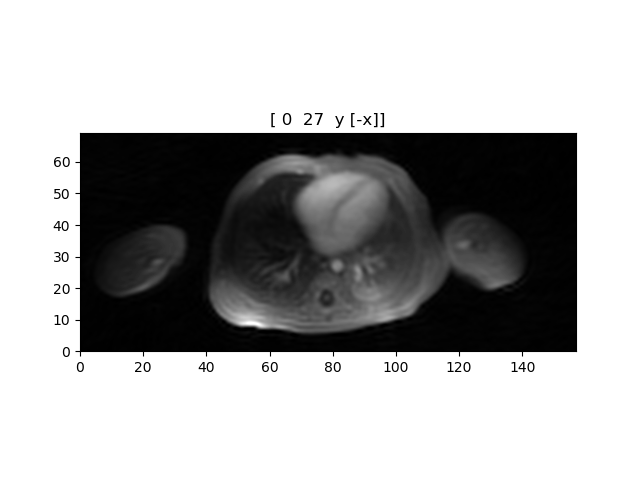

In [0]:
grd = gridding_recon(ksp, coord, dcf, device=device)

#Plot
pl.ImagePlot(grd, interpolation='lanczos')

# Generate Sensitivity Maps

We will need to estimate the sensitivity maps to incorporate multi-channel data. 

For this demo, we will use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245), which has a fast implementation in SigPy.

<IPython.core.display.Javascript object>


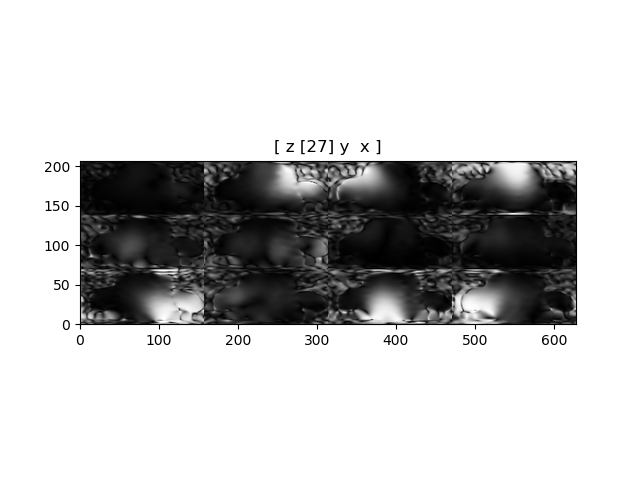

In [0]:
mps = mr.app.JsenseRecon(ksp, coord=coord, weights=dcf, device=device).run()

# Plot
pl.ImagePlot(mps, z=0, interpolation='lanczos')

# Multi-scale Low Rank Reconstruction

The following runs the multi-scale low rank reconstruction with 20 frames.

In this implementation, there is an initialization phase with power methods to initialize the singular vectors. Then, the reconstruction will run stochastic gradient method with a default of 90 epochs.

Note that this can be rather slow depending on your computing device. As a reference, on a single GPU we tried, the low resolution reconstruction took ~8 minutes.

In [0]:
T = 20
lamda = 1e-8
img = MultiScaleLowRankRecon(ksp, coord, dcf, mps, T, lamda, device=device).run()



Reconstruction diverged. Restart with alpha=7.79.


# Plot

The returned image is stored in a compressed multi-scale low rank representation, and NOT a numpy array. This is useful when the underlying image is huge.

The image can be indexed, and will adaptively reconstruct the indexed slice. In particular, it can be viewed directly using `pl.ImagePlot`. You can speed up the slicing with the desired computing device using `img.use_device(device)`.

To obtain a numpy array from the compressed representation, you can do:

    img = img[:]
    
But note that this will expand the underlying image completely, which can take a lot of memory.

<IPython.core.display.Javascript object>


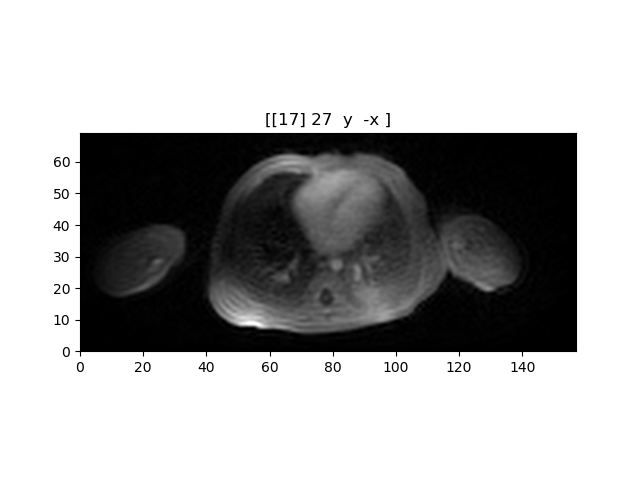

In [0]:
img.use_device(device)
pl.ImagePlot(img, interpolation='lanczos')